# Домашнее задание №1 - Применение методов NLP


В этом домашнем задании мы будем работать с данными из сорневнования: 
[Toxic comment classification challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)
  
  
В задании небходимо по тексту комментария определить веротяности следующих категорий:
- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

Как и в соревновании мы везде будем использовать метрику ROC AUC для валидации

_Обратите внимание, что каждый комментарий может иметь несколько меток разных классов_

### Что нужно сделать? 

1. Подготовка __[10%]__:
    - Скачайте данные, проведите первоначальные EDA: баланс классов, пересечение классов и т.д. 
    - Придумайте и обоснуйте стратегию валидации. 
    - Сделайте предбработку данных. Оцените что требуется делать с символами, заглавными буквами. Проведите лемматизацию или стеминг.
2. Примените любой Embedding (word2vec или Glove) __[5%]__
3. Постройте следующие модели (для каждой необходимо самостоятельно выбрать оптимальное количество слоеев и архитектуру, оценить качество, переобученность, построить кривые обучения и валидации, сделать выводы по примению модели):
    - Одномерные свертки __[20%]__
    - LSTM или GRU __[20%]__
    - Bidirectional LSTM __[20%]__   
4. Попробуйте применить к этой задаче BERT или GPT-2. Выбор оптимального количества слоеев и архитектура на ваш вкус (но не забудьте обосновать его). Оцените качетво и другие параметры работы модели. __[25%]__

#### Дополнительные 50%

5. Основываясь на полученных результатах, сделайте свою лучшую модель и сделайте Late Submission на тестовых данных [challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). Не забудьте <u>приложить</u> скриншот с Вашим скором. Скриншот вставьте прямо в ноутбук с решением или выведите в stdout. 

  
  
______
_Правила полученения дополнительных баллов:_
- можно получить от 20% до 50% в зависимости от метрики качества других участников нашего курса полученного на лидерборде
- Чтобы получить минимум в 20% нужно: 
    - Основные задания должны быть полностью решены
    - Обосновать то решение которое отправили.
    - Предложенная модель должна отличаться от тех, что строились в заданиях 2-4
    
Готовый ноутбук загрузите в эту форму: [http://bit.ly/dafe_hw](http://bit.ly/dafe_hw)


In [1]:
# import ruquired libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

#settings
color = sns.color_palette()
sns.set_style("dark")
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# load dataset

train_path = 'jigsaw-toxic-comment-classification-challenge/train.csv'
test_path = 'jigsaw-toxic-comment-classification-challenge/test.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

## General EDA 

In [3]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
print(f'train rows: {df_train.shape[0]} \n'
     f'test rows: {df_test.shape[0]}')

train rows: 159571 
test rows: 153164


In [5]:
x = df_train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums = df_train.iloc[:,2:].sum(axis=1)
df_train['clean'] = (rowsums == 0)
#count number of clean entries
df_train['clean'].sum()
print(f"Total comments = {len(df_train)}")
print(f"Total clean comments = {df_train['clean'].sum()}")
print(f"Total tags = {x.sum()}")

Total comments = 159571
Total clean comments = 143346
Total tags = 35098


In [6]:
print("Check for missing values in Train dataset")
null_check = df_train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check = df_test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
df_train["comment_text"].fillna("unknown", inplace=True)
df_test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with "unknown"


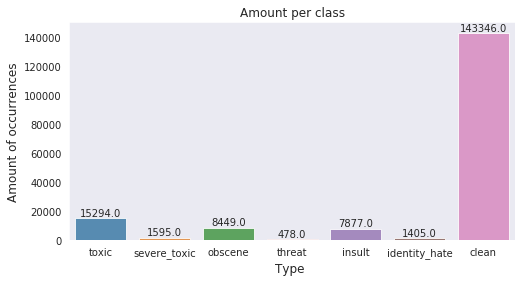

In [7]:
x = df_train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Amount per class")
plt.ylabel('Amount of occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

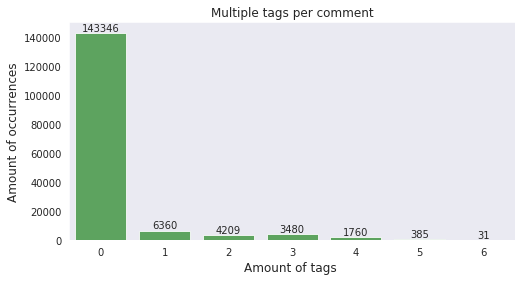

In [8]:
x = rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('Amount of occurrences', fontsize=12)
plt.xlabel('Amount of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

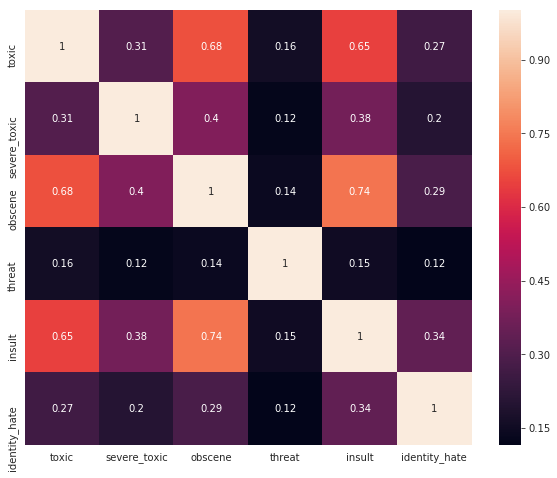

In [9]:
temp_df = df_train.iloc[:,2:-1]
# filter temp by removing clean comments
# temp_df = temp_df[~df_train.clean]

corr = temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, 
            annot=True)

plt.show()